# Exporatory Data Analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import data from preprocessing phase
df = pd.read_csv("data/merged_data.csv")
print(f"Imported Data Shape: {df.shape}")

# check for duplicates
duplicates = df.duplicated().sum().sum()
print(f"Duplicates in Merged Dataframe: {duplicates}")

# evaluate dataset sparsity
#global_mutation_rate = df[gene_columns].mean().mean()
#print(f"Global Mutation Rate: {global_mutation_rate}")

Imported Data Shape: (199964, 1789)
Duplicates in Merged Dataframe: 0


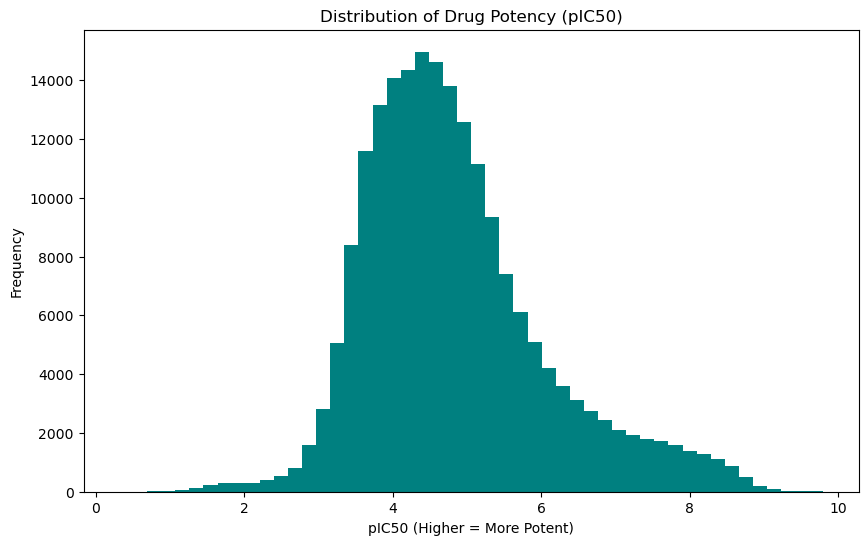

In [3]:
# create histogram of IC50 values
plt.figure(figsize=(10,6))
plt.hist(df['pic50'], bins=50, color='teal')
plt.title('Distribution of Drug Potency (pIC50)')
plt.xlabel('pIC50 (Higher = More Potent)')
plt.ylabel('Frequency')
plt.savefig('outputs/Distribution of Drug Potency (pIC50).png')
plt.show()

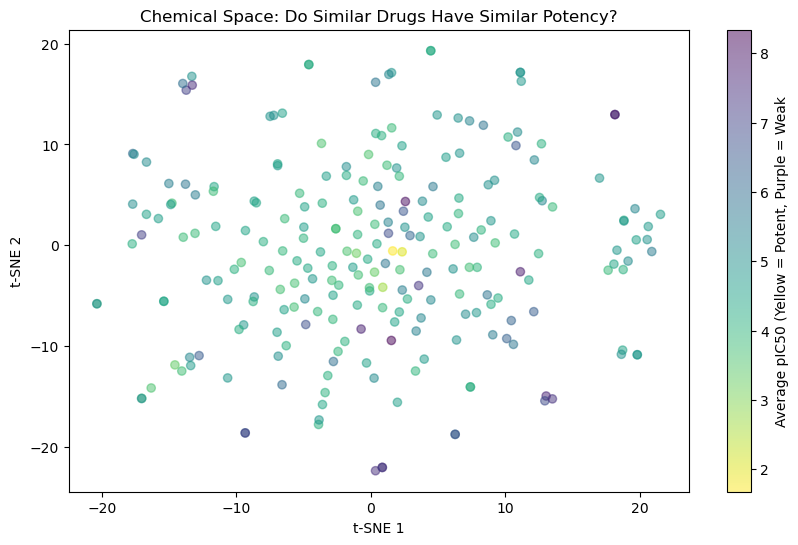

In [8]:
# conduct Principal Component Analyis (PCA)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# obtain unique drugs and extract fingerprints
drug_potency = df.groupby('drug_id')['pic50'].median().reset_index()

fp_columns = [c for c in df.columns if c.startswith('FP_')]
meta_columns = ['drug_id', 'drug_name', 'tissue_sub_type']

drug_structure = df[meta_columns + fp_columns].drop_duplicates(subset=['drug_id'])

unique_drugs = pd.merge(drug_potency, drug_structure, on='drug_id')

X_fp = unique_drugs[fp_columns]

# PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(X_fp)

# TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=1)
tsne_result = tsne.fit_transform(pca_result)

# plot
plt.figure(figsize=(10,6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
            c=unique_drugs['pic50'], cmap='viridis_r', alpha=0.5)
plt.colorbar(label='Average pIC50 (Yellow = Potent, Purple = Weak')
plt.title('Chemical Space: Do Similar Drugs Have Similar Potency?')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig('outputs/Chemical Space Do Similar Drugs Have Similar Potency.png')
plt.show()

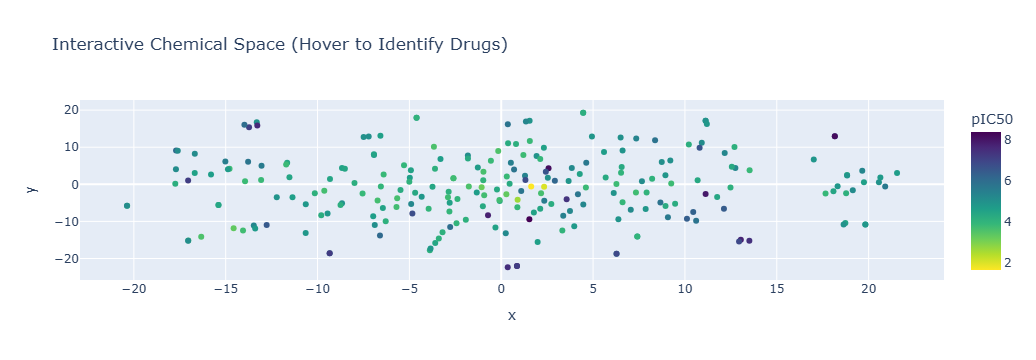

In [9]:
# create interactive plot
import plotly.express as px

plot_df = pd.DataFrame({
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1],
    'pIC50': unique_drugs['pic50'],
    'Drug Name': unique_drugs['drug_name'],
    'Target Pathway': unique_drugs['tissue_sub_type']
})

fig = px.scatter(plot_df, x='x', y='y',
                 color='pIC50',
                 hover_data=['Drug Name', 'pIC50'],
                 color_continuous_scale='viridis_r',
                 title='Interactive Chemical Space (Hover to Identify Drugs)')
fig.show()

Top Mutated Gene: TP53_mut


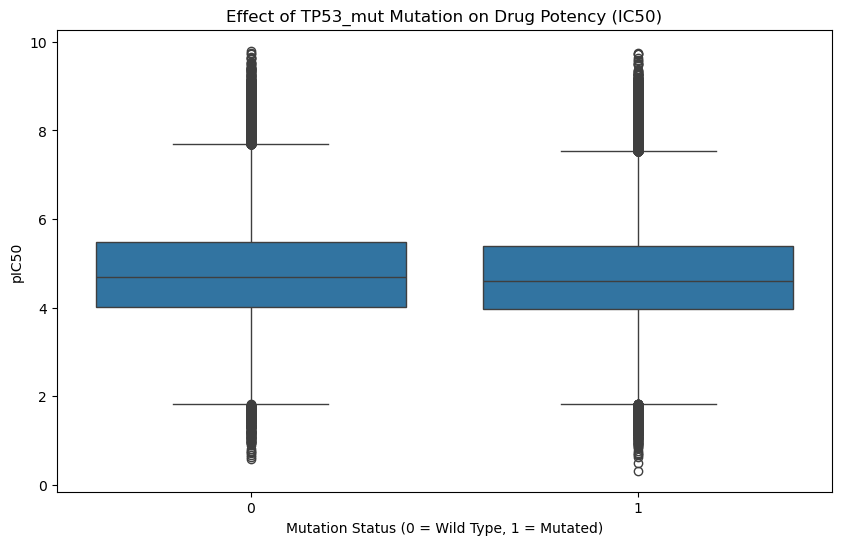

In [13]:
# identify top mutated gene and plot
gene_columns = [c for c in df.columns if "_mut" in c]
mutation_counts = df[gene_columns].sum().sort_values(ascending=False)
top_gene = mutation_counts.index[0]
print(f"Top Mutated Gene: {top_gene}")

plt.figure(figsize=(10,6))
sns.boxplot(x=top_gene, y='pic50', data=df)
plt.title(f'Effect of {top_gene} Mutation on Drug Potency (IC50)')
plt.xlabel('Mutation Status (0 = Wild Type, 1 = Mutated)')
plt.ylabel('pIC50')
plt.savefig(f'outputs/Effect of {top_gene} Mutation on Drug Potency (pIC50).png')
plt.show()

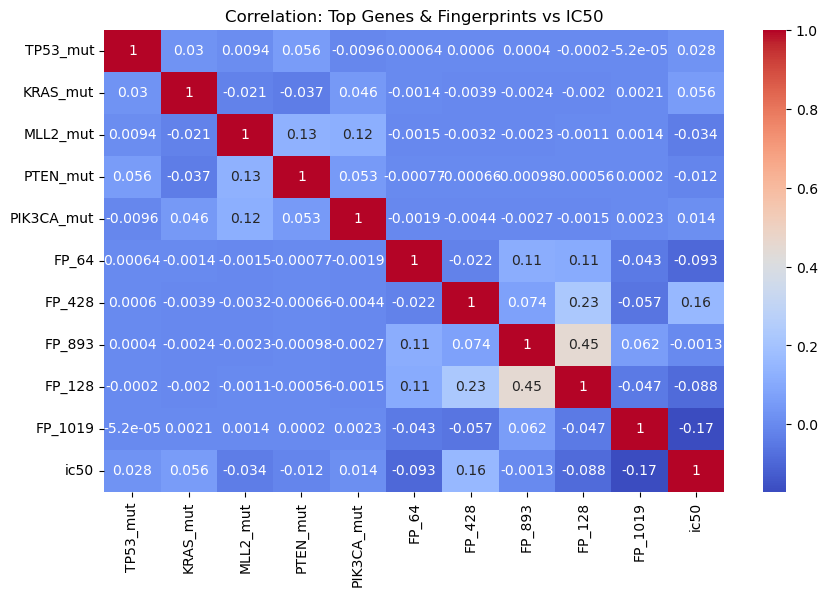

In [14]:
# correlation heatmap
top_genes = mutation_counts.head(5).index.tolist()
top_fps = df[fp_columns].var().sort_values(ascending=False).head(5).index.tolist()

selected_cols = top_genes + top_fps + ['ic50']
corr_matrix = df[selected_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation: Top Genes & Fingerprints vs IC50')
plt.savefig('outputs/Correlation Heatmap.png')
plt.show()